# _Predict whether income exceeds $50K/yr based on census data_

## Setup

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

from altair import Chart, Color, Scale

from IPython.display import display

from matplotlib import rcParams

sns.set(style='ticks', palette='Set2')

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
pd.set_option('display.max_columns', 9999)

## Dataset

**Attributes:**  
< 50K, <=50K  
**age:** continuous
**workclass:** Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked  
**fnlwgt:** continuous  
**education:** Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool  
**education-num:** continuous  
**marital-status:** Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse  
**occupation:** Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces  
**relationship:** Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried  
**race:** White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black  
**sex:** Female, Male  
**capital-gain:** continuous  
**capital-loss:** continuous  
**hours-per-week:** continuous  
**native-country:** United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands  

In [5]:
# load the dataset

df=pd.read_csv('adult.csv')
df.sample(3)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
21446,17,?,161981,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
678,41,Self-emp-not-inc,186909,Masters,14,Married-civ-spouse,Sales,Wife,White,Female,0,1902,35,United-States,>50K
29507,59,Private,81973,Masters,14,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>50K


### Data cleaning

In [6]:
# rename columns

df.rename(columns={'education.num': 'education_num'}, inplace=True)
df.rename(columns={'marital.status': 'marital_status'}, inplace=True)
df.rename(columns={'capital.gain': 'capital_gain'}, inplace=True)
df.rename(columns={'capital.loss': 'capital_loss'}, inplace=True)
df.rename(columns={'hours.per.week': 'hours_per_week'}, inplace=True)
df.rename(columns={'native.country': 'native_country'}, inplace=True)
df.head(3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K


In [7]:
#info 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
# dimension of the dataset (row, columns)

df.shape

(32561, 15)

In [9]:
# checking missing value

print(df.columns[df.isnull().any()])
df.isnull().values.any()

Index([], dtype='object')


False

In [10]:
#checking if column contains value '?'

col_df=df.isin(['?'])
col_df.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [11]:
# Columns with value '?'

s=col_df.apply(pd.Series.nunique)
s_df=pd.DataFrame(s, columns=['no'])
s_df[s_df.no==2]

,no
workclass,2
occupation,2
native_country,2


In [12]:
# 'workclass' unique values
print(df.workclass.unique())

# Count entries for each types
print(df['workclass'].value_counts())

['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64


In [13]:
# 'occupation' unique values
print(df.occupation.unique())

# Count entries for each types
print(df['occupation'].value_counts())

['?' 'Exec-managerial' 'Machine-op-inspct' 'Prof-specialty' 'Other-service'
 'Adm-clerical' 'Craft-repair' 'Transport-moving' 'Handlers-cleaners'
 'Sales' 'Farming-fishing' 'Tech-support' 'Protective-serv' 'Armed-Forces'
 'Priv-house-serv']
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64


In [14]:
# 'native_country' unique values
print(df.workclass.unique())

# Count entries for each types
print(df['native_country'].value_counts())

['?' 'Private' 'State-gov' 'Federal-gov' 'Self-emp-not-inc' 'Self-emp-inc'
 'Local-gov' 'Without-pay' 'Never-worked']
United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal          

In [15]:
# Renaming '?' in  columns 'workclass', 'occupation', 'native_country'

df['workclass']=df['workclass'].replace('?','other')
df['occupation']=df['occupation'].replace('?','other')
df['native_country']=df['native_country'].replace('?','other')
df.head(3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,other,77053,HS-grad,9,Widowed,other,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,other,186061,Some-college,10,Widowed,other,Unmarried,Black,Female,0,4356,40,United-States,<=50K


In [16]:
# Double-check

from pandasql import sqldf
from pandasql import *

pysqldf = lambda q: sqldf(q, globals())

q  = """
SELECT
  income
FROM
  df
WHERE
  workclass = '?'OR
  occupation='?'OR
  native_country='?';
"""

print (sqldf(q, locals()))

Empty DataFrame
Columns: [income]
Index: []


## Data exploration

In [17]:
# Calculate the the average of values
df.groupby('income').mean()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
income,,,,,,
<=50K,36.783738,190340.86517,9.595065,148.752468,53.142921,38.840210
>50K,44.249841,188005.00000,11.611657,4006.142456,195.001530,45.473026


### Contingency tables

In [18]:
contingency_table_workclass=pd.crosstab(df['income'],df['workclass'])
contingency_table_education=pd.crosstab(df['income'],df['education'])
contingency_table_marital_status=pd.crosstab(df['income'],df['marital_status'])
contingency_table_race=pd.crosstab(df['income'],df['race'])
contingency_table_sex=pd.crosstab(df['income'],df['sex'])
contingency_table_native_country=pd.crosstab(df['income'],df['native_country'])

display(contingency_table_workclass)
display(contingency_table_education)
display(contingency_table_marital_status)
display(contingency_table_race)
display(contingency_table_sex)
display(contingency_table_native_country)

workclass,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,other
income,,,,,,,,,
<=50K,589,1476,7,17733,494,1817,945,14,1645
>50K,371,617,0,4963,622,724,353,0,191


education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
income,,,,,,,,,,,,,,,,
<=50K,871,1115,400,162,317,606,487,802,1021,3134,107,8826,764,51,153,5904
>50K,62,60,33,6,16,40,27,265,361,2221,306,1675,959,0,423,1387


marital_status,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
income,,,,,,,
<=50K,3980,13,8284,384,10192,959,908
>50K,463,10,6692,34,491,66,85


race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
income,,,,,
<=50K,275,763,2737,246,20699
>50K,36,276,387,25,7117


sex,Female,Male
income,,
<=50K,9592,15128
>50K,1179,6662


native_country,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,Germany,Greece,Guatemala,Haiti,Holand-Netherlands,Honduras,Hong,Hungary,India,Iran,Ireland,Italy,Jamaica,Japan,Laos,Mexico,Nicaragua,Outlying-US(Guam-USVI-etc),Peru,Philippines,Poland,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,other
income,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
<=50K,12,82,55,57,70,68,24,97,60,17,93,21,61,40,1,12,14,10,60,25,19,48,71,38,16,610,32,14,29,137,48,33,102,9,64,31,15,17,21999,62,10,437
>50K,7,39,20,2,25,2,4,9,30,12,44,8,3,4,0,1,6,3,40,18,5,25,10,24,2,33,2,0,2,61,12,4,12,3,16,20,3,2,7171,5,6,146


### Distribution of income per feature

In [19]:
# Ratio / distribution of income among genders
display(contingency_table_sex.astype('float').div(contingency_table_sex.sum(axis=1),axis=0))
# Ratio / distribution of income per gender
display(contingency_table_sex.astype('float').div(contingency_table_sex.sum(axis=0),axis=1))

sex,Female,Male
income,,
<=50K,0.388026,0.611974
>50K,0.150363,0.849637


sex,Female,Male
income,,
<=50K,0.890539,0.694263
>50K,0.109461,0.305737


In [20]:
# Ratio / distribution of income per workclass / education / material_status / race / native_country
display(contingency_table_workclass.astype('float').div(contingency_table_workclass.sum(axis=0),axis=1))
display(contingency_table_education.astype('float').div(contingency_table_education.sum(axis=0),axis=1))
display(contingency_table_marital_status.astype('float').div(contingency_table_marital_status.sum(axis=0),axis=1))
display(contingency_table_race.astype('float').div(contingency_table_race.sum(axis=0),axis=1))
display(contingency_table_native_country.astype('float').div(contingency_table_native_country.sum(axis=0),axis=1))

workclass,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,other
income,,,,,,,,,
<=50K,0.613542,0.705208,1.0,0.781327,0.442652,0.715073,0.728043,1.0,0.895969
>50K,0.386458,0.294792,0.0,0.218673,0.557348,0.284927,0.271957,0.0,0.104031


education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
income,,,,,,,,,,,,,,,,
<=50K,0.933548,0.948936,0.923788,0.964286,0.951952,0.93808,0.947471,0.75164,0.738784,0.585247,0.25908,0.840491,0.443413,1.0,0.265625,0.809765
>50K,0.066452,0.051064,0.076212,0.035714,0.048048,0.06192,0.052529,0.24836,0.261216,0.414753,0.74092,0.159509,0.556587,0.0,0.734375,0.190235


marital_status,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed
income,,,,,,,
<=50K,0.895791,0.565217,0.553152,0.91866,0.954039,0.93561,0.914401
>50K,0.104209,0.434783,0.446848,0.08134,0.045961,0.06439,0.085599


race,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White
income,,,,,
<=50K,0.884244,0.73436,0.87612,0.907749,0.74414
>50K,0.115756,0.26564,0.12388,0.092251,0.25586


native_country,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,England,France,Germany,Greece,Guatemala,Haiti,Holand-Netherlands,Honduras,Hong,Hungary,India,Iran,Ireland,Italy,Jamaica,Japan,Laos,Mexico,Nicaragua,Outlying-US(Guam-USVI-etc),Peru,Philippines,Poland,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia,other
income,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
<=50K,0.631579,0.677686,0.733333,0.966102,0.736842,0.971429,0.857143,0.915094,0.666667,0.586207,0.678832,0.724138,0.953125,0.909091,1.0,0.923077,0.7,0.769231,0.6,0.581395,0.791667,0.657534,0.876543,0.612903,0.888889,0.948678,0.941176,1.0,0.935484,0.691919,0.8,0.891892,0.894737,0.75,0.8,0.607843,0.833333,0.894737,0.754165,0.925373,0.625,0.749571
>50K,0.368421,0.322314,0.266667,0.033898,0.263158,0.028571,0.142857,0.084906,0.333333,0.413793,0.321168,0.275862,0.046875,0.090909,0.0,0.076923,0.3,0.230769,0.4,0.418605,0.208333,0.342466,0.123457,0.387097,0.111111,0.051322,0.058824,0.0,0.064516,0.308081,0.2,0.108108,0.105263,0.25,0.2,0.392157,0.166667,0.105263,0.245835,0.074627,0.375,0.250429


### Encoding

In [21]:
# Encoding - Transforming the prediction target (income)
# 0 : <=50K , 1 : >50K
from sklearn import preprocessing

dfe=df.copy()

label_encoder = preprocessing.LabelEncoder()
dfe['income'] = label_encoder.fit_transform(dfe['income'])
dfe.head(3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,other,77053,HS-grad,9,Widowed,other,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,other,186061,Some-college,10,Widowed,other,Unmarried,Black,Female,0,4356,40,United-States,0


In [22]:
# encoding - Pandas One-hot

dfn=dfe.drop(dfe[['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race','sex', 'native_country']], axis=1)

dfm = pd.DataFrame()

df_workclass=pd.get_dummies(dfe['workclass'], prefix='workclass')
df_education=pd.get_dummies(dfe['education'], prefix='education')
df_marital_status=pd.get_dummies(dfe['marital_status'], prefix='marital_status')
df_occupation=pd.get_dummies(dfe['occupation'], prefix='occupation')
df_relationship=pd.get_dummies(dfe['relationship'], prefix='relationship')
df_race=pd.get_dummies(dfe['race'], prefix='race')
df_sex=pd.get_dummies(dfe['sex'], prefix='sex')
df_native_country=pd.get_dummies(dfe['native_country'], prefix='native_country')
dfm = pd.concat([dfm,dfn, df_workclass,df_education,df_marital_status, df_occupation,df_relationship,df_race, df_sex,df_native_country ], axis=1)

dfm.head(5)

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_other,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital_status_Divorced,marital_status_Married-AF-spouse,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,occupation_other,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,native_country_Cambodia,native_country_Canada,native_country_China,native_country_Columbia,native_country_Cuba,native_country_Dominican-Republic,native_country_Ecuador,native_country_El-Salvador,native_country_England,native_country_France,native_country_Germany,native_country_Greece,native_country_Guatemala,native_country_Haiti,native_country_Holand-Netherlands,native_country_Honduras,native_country_Hong,native_country_Hungary,native_country_India,native_country_Iran,native_country_Ireland,native_country_Italy,native_country_Jamaica,native_country_Japan,native_country_Laos,native_country_Mexico,native_country_Nicaragua,native_country_Outlying-US(Guam-USVI-etc),native_country_Peru,native_country_Philippines,native_country_Poland,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia,native_country_other
0,90,77053,9,0,4356,40,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,82,132870,9,0,4356,18,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,66,186061,10,0,4356,40,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,54,140359,4,0,3900,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,41,264663,10,0,3900,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [23]:
# Colums in dataframe 'dfm'

for col in dfm.columns:
    print(col)

age
fnlwgt
education_num
capital_gain
capital_loss
hours_per_week
income
workclass_Federal-gov
workclass_Local-gov
workclass_Never-worked
workclass_Private
workclass_Self-emp-inc
workclass_Self-emp-not-inc
workclass_State-gov
workclass_Without-pay
workclass_other
education_10th
education_11th
education_12th
education_1st-4th
education_5th-6th
education_7th-8th
education_9th
education_Assoc-acdm
education_Assoc-voc
education_Bachelors
education_Doctorate
education_HS-grad
education_Masters
education_Preschool
education_Prof-school
education_Some-college
marital_status_Divorced
marital_status_Married-AF-spouse
marital_status_Married-civ-spouse
marital_status_Married-spouse-absent
marital_status_Never-married
marital_status_Separated
marital_status_Widowed
occupation_Adm-clerical
occupation_Armed-Forces
occupation_Craft-repair
occupation_Exec-managerial
occupation_Farming-fishing
occupation_Handlers-cleaners
occupation_Machine-op-inspct
occupation_Other-service
occupation_Priv-house-serv


## Correlation

In [24]:
dfm.corr()[['income']].sort_values(by='income', ascending=False)

,income
income,1.000000
marital_status_Married-civ-spouse,0.444696
relationship_Husband,0.401035
education_num,0.335154
age,0.234037
hours_per_week,0.229689
capital_gain,0.223329
sex_Male,0.215980
occupation_Exec-managerial,0.214861
occupation_Prof-specialty,0.185866


## Feature selection

In [25]:
# no. of rows & columns
dfm.shape

(32561, 109)

In [26]:
dfm_vars=dfm.columns.values.tolist()
Y_feature=['income']
X_feature=[i for i in dfm_vars if i not in Y_feature]

In [27]:
# Using Recursive feature elimination (RFE) for feature selection
#True / 1 features should select

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

rfe = RFE(model) # n_features_to_select -->sum of col
rfe = rfe.fit(dfm[X_feature],dfm[Y_feature].values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False  True False  True False  True
  True  True  True  True  True  True False False  True  True  True  True
 False  True  True  True  True  True  True False  True  True False  True
 False False False False False  True  True  True  True  True  True  True
  True False  True False  True False False  True  True False  True  True
 False False  True False  True False False  True False  True False  True
 False  True  True  True  True False False False False False False False
 False False False  True False  True False  True  True  True  True  True
 False False False False False False False False  True  True False False]
[34 42 13 41 40 32 30  1 48  1 37  1  1  1  1  1  1  1 28 24  1  1  1  1 31
  1  1  1  1  1  1  7  1  1  6  1  5 10 33 50 39  1  1  1  1  1  1  1  1  3
  1 27  1  9 29  1  1  8  1  1 18 17  1 19  1 12 49  1 52  1  2  1 21  1  1
  1  1 15 36 25 54 46 47 53 11 14 45  1 38  1 44  1  1  1  1  1 22 26 16 55
  4 20 51 23  1  1 43 35]


In [28]:
feature_list=[i for i,x in enumerate(rfe.ranking_) if x == 1]
feature_list

[7,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 32,
 33,
 35,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 52,
 55,
 56,
 58,
 59,
 62,
 64,
 67,
 69,
 71,
 73,
 74,
 75,
 76,
 87,
 89,
 91,
 92,
 93,
 94,
 95,
 104,
 105]

In [29]:
dfmv = dfm.columns.values
selected_feature_cols=[ dfmv[i] for i in feature_list ]
selected_feature_cols

['workclass_Federal-gov',
 'workclass_Never-worked',
 'workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'workclass_other',
 'education_10th',
 'education_11th',
 'education_5th-6th',
 'education_7th-8th',
 'education_9th',
 'education_Assoc-acdm',
 'education_Bachelors',
 'education_Doctorate',
 'education_HS-grad',
 'education_Masters',
 'education_Preschool',
 'education_Prof-school',
 'marital_status_Divorced',
 'marital_status_Married-AF-spouse',
 'marital_status_Married-spouse-absent',
 'occupation_Craft-repair',
 'occupation_Exec-managerial',
 'occupation_Farming-fishing',
 'occupation_Handlers-cleaners',
 'occupation_Machine-op-inspct',
 'occupation_Other-service',
 'occupation_Priv-house-serv',
 'occupation_Prof-specialty',
 'occupation_Sales',
 'occupation_Transport-moving',
 'relationship_Not-in-family',
 'relationship_Other-relative',
 'relationship_Unmarried',
 'relationship_Wife',
 'race_Black',
 'race_White',
 'nat

In [30]:
X = dfm[selected_feature_cols]
Y = dfm['income'].values

## Statsmodels

In [31]:
# overview of the coefficients of the model
import statsmodels.api as sm

logit_model=sm.Logit(Y,X)
result=logit_model.fit(maxiter=40)
print(result.summary())

         Current function value: 0.413181
         Iterations: 40
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                32561
Model:                          Logit   Df Residuals:                    32507
Method:                           MLE   Df Model:                           53
Date:                Thu, 20 Apr 2017   Pseudo R-squ.:                  0.2515
Time:                        23:42:19   Log-Likelihood:                -13454.
converged:                      False   LL-Null:                       -17974.
                                        LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
workclass_Federal-gov                         0.5850      0.081      7.224      0.

/Users/bernadett/miniconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [32]:
# confidence interval of each coeffecient
result.conf_int()

,0,1
workclass_Federal-gov,4.262897e-01,7.437066e-01
workclass_Never-worked,-5.414871e+69,5.414871e+69
workclass_Self-emp-inc,6.090121e-01,8.988929e-01
workclass_Self-emp-not-inc,-1.588278e-01,6.209695e-02
workclass_State-gov,-5.049310e-01,-1.984307e-01
workclass_Without-pay,-4.588437e+07,4.588430e+07
workclass_other,-1.265423e+00,-9.175094e-01
education_10th,-1.363902e+00,-8.146524e-01
education_11th,-1.712123e+00,-1.167397e+00
education_5th-6th,-1.525934e+00,-4.496245e-01


## Scaling

In [33]:
# Scale data
from sklearn.preprocessing import RobustScaler, StandardScaler
X = StandardScaler().fit_transform(X)

## Model Implementation

In [34]:
from sklearn import linear_model

clf = linear_model.LogisticRegression()
clf.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
clf.score(X,Y)

0.81480912748379963

## Model validation

In [36]:
# Split to train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [37]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [169]:
from xgboost import XGBClassifier
cx = XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.05)
cx.fit(X_train, y_train)
cx.score(X_test, y_test)

0.81090211132437617

In [38]:
# calculate the percentage of 0, 1
print( '<=50K',1-y_test.mean())
print( ' >50K',y_test.mean())

<=50K 0.758541266795
 >50K 0.241458733205


In [39]:
clf_log.score(X_test, y_test)

0.81205374280230325

### Model accuracy

In [40]:
# Predicted
y_pred= clf_log.predict(X_test)
predicted = y_pred
predicted

array([0, 0, 0, ..., 0, 0, 1])

In [41]:
# True
y_test

array([0, 0, 0, ..., 1, 0, 1])

In [42]:
# Comparing the true and predicted response values

print('True     ', y_test[:20])
print('Predicted', predicted[:20])

True      [0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0]
Predicted [0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0]


In [44]:
# Predict class labels for samples in X
y_probs = clf_log.predict_proba(X_test)
y_probs

array([[ 0.97958882,  0.02041118],
       [ 0.89083653,  0.10916347],
       [ 0.99003505,  0.00996495],
       ..., 
       [ 0.85997418,  0.14002582],
       [ 0.85624359,  0.14375641],
       [ 0.16283304,  0.83716696]])

In [45]:
# Probabilities for class 0 (=<50K)
prob_0=y_probs[:,0]
prob_0

array([ 0.97958882,  0.89083653,  0.99003505, ...,  0.85997418,
        0.85624359,  0.16283304])

In [46]:
# Probabilities for class 1 (>50K)
prob_1=y_probs[:,1]
prob_1

array([ 0.02041118,  0.10916347,  0.00996495, ...,  0.14002582,
        0.14375641,  0.83716696])

In [63]:
# cross-entropy loss
from sklearn.metrics import log_loss
log_loss(y_test, y_probs)

0.41420072165739474

In [48]:
# Accuracy classification score
from sklearn import metrics

metrics.accuracy_score(y_test, y_pred)

0.81205374280230325

### Cross validation  
_evaluating estimator performance_

In [49]:
from sklearn.model_selection import cross_val_score

clf_cross_val = linear_model.LogisticRegression()
scores = cross_val_score(clf_cross_val, X, Y, scoring='accuracy', cv=5)
scores

array([ 0.83079994,  0.80543612,  0.80635749,  0.81802826,  0.80850737])

In [50]:
scores.mean()

0.81382583538272146

In [51]:
# Generate cross-validated estimates for each input data point
from sklearn.model_selection import cross_val_predict

predicted_cross_val = cross_val_predict(clf, X, Y, cv=10)
metrics.accuracy_score(Y, predicted_cross_val) 

0.81391849144682293

## Model validation

### Confusion matrix  
_evaluating classifier performance_

In [52]:
from sklearn.metrics import confusion_matrix

metrics.confusion_matrix(y_test, y_pred)

array([[9263,  617],
       [1831, 1314]])

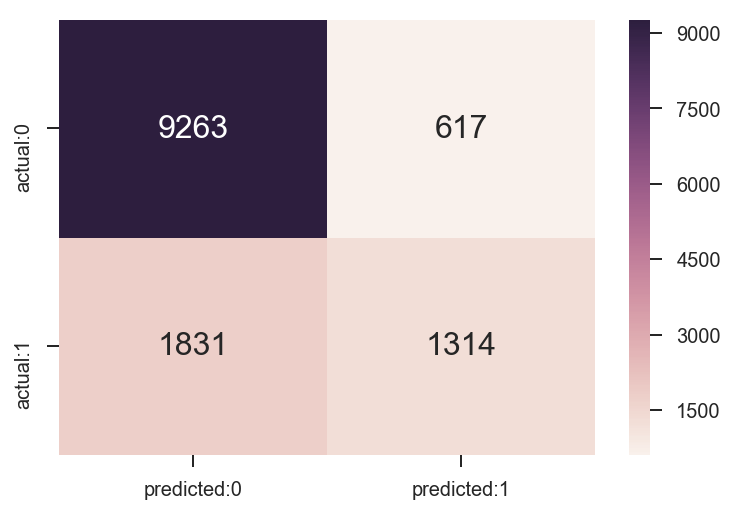

In [53]:
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index=["actual:0","actual:1"], columns=["predicted:0","predicted:1"])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d")
plt.figure(figsize = (10,7))
plt.show()

In [54]:
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print('TP',TP)
print('TN',TN)
print('FP',FP)
print('FN',FN)

TP 1314
TN 9263
FP 617
FN 1831


True Positives(TP): actual 1, predicted 1: we correctly predicted 1 (income is >50K) - 1314  
True Negatives(TN): actual 0, predicted 0: we correctly predicted 0 (income is <=50K) - 9263   
False Positives(FP): actual 0, predicted 1: we incorrectly predicted 1 ("Type I error") (income is >50K) - 617   
False Negatives(FN): actual 1, predicted 0: we incorrectly predicted 0 ("Type II error")(income is <=50K) - 1831 

In [55]:
# Classification Accuracy (ratio of correct classifier)
# (TP + TN) / float(TP + TN + FP + FN)
metrics.accuracy_score(y_test, y_pred)

0.81205374280230325

In [56]:
# Classification Error (ratio of incorrect classifier)
# (FP + FN) / float(TP + TN + FP + FN)
1 - metrics.accuracy_score(y_test, y_pred)

0.18794625719769675

In [57]:
# Sensitivity (Recall or TPR)
# TP / float(TP + FN)
metrics.recall_score(y_test, y_pred)

0.41780604133545313

In [58]:
# Specificity (True Negative Rate)
TN / float(TN + FP)

0.93755060728744943

In [59]:
# 1-Specicity (FPR)
FP / float(TN + FP)

0.062449392712550608

In [60]:
# Precision 
# TP / float(TP + FP)
metrics.precision_score(y_test, y_pred)

0.68047643707923355

In [61]:
#F1 score
# 2 * (precision * recall) / (precision + recall)
metrics.f1_score(y_test, y_pred)

0.51773049645390079

In [139]:
# Number of times a predicted probability is assigned to an observation
counts_0 = pd.value_counts(prob_0)
counts_1 = pd.value_counts(prob_1)

In [138]:
data_counts_0=pd.DataFrame(counts_0)
data_counts_0 = data_counts_0.reset_index()
data_counts_0.columns = ['prob0','counts_0']
data_counts_0.head(10)

,prob0,counts_0
0,0.714546,373
1,0.758164,236
2,0.704367,221
3,0.305418,213
4,0.676662,211
5,0.813831,178
6,0.733538,176
7,0.436142,172
8,0.789471,162
9,0.740252,152


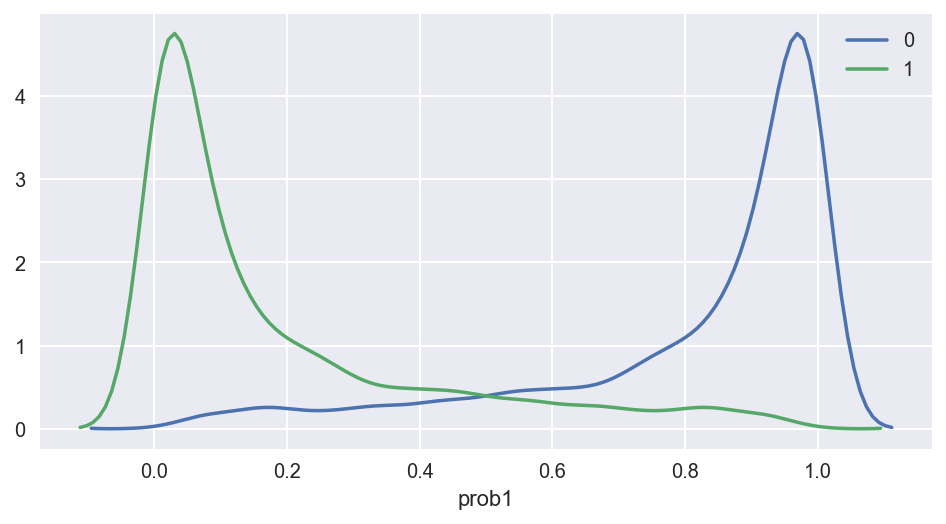

In [166]:
sns.set(rc={"figure.figsize": (8, 4)}); np.random.seed(0)

f, ax = plt.subplots()

x=data_counts_0['prob0']
x=pd.Series(x, name="prob0")
sns.distplot(x, rug=False, hist=False, ax=ax, label='0')

x=data_counts_1['prob1']
x=pd.Series(x, name="prob1")
sns.distplot(x, rug=False, hist=False, ax=ax, label='1')

In [154]:
data_counts_1=pd.DataFrame(counts_1)
data_counts_1 = data_counts_1.reset_index()
data_counts_1.columns = ['prob1','counts_1']
data_counts_1.head(10)

,prob1,counts_1
0,0.285454,373
1,0.241836,236
2,0.295633,221
3,0.694582,213
4,0.323338,211
5,0.186169,178
6,0.266462,176
7,0.563858,172
8,0.210529,162
9,0.259748,152


### ROC curve (Receiver Operating Characteristic)

An ROC curve is a plot of Sensitivity(Recall/TPR) vs 1-Specificity (FPR)

### Predicted 1

In [91]:
from sklearn import metrics

# fpr = false positive rate, Positives(FP): actual 0, predicted 1: we incorrectly predicted 1 ("Type I error")
# tpr = true positve rate, Positives(TP): actual 1, predicted 1: we correctly predicted 1

# Determine the false positive and true positive rates
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_1)
print('1-Specificity       ',fpr)
print('Sensitivity (Recall)',tpr)
print('thresholds          ',thresholds)

1-Specificity        [ 0.          0.          0.         ...,  0.9992915   0.99949393  1.        ]
Sensitivity (Recall) [  3.17965024e-04   6.35930048e-04   1.27186010e-03 ...,   1.00000000e+00
   1.00000000e+00   1.00000000e+00]
thresholds           [  9.83265215e-01   9.64249687e-01   9.63199055e-01 ...,   5.44452257e-05
   4.76697369e-05   8.84267342e-06]


In [103]:
ROC_curve_df=pd.DataFrame({'thresholds (p)' : thresholds,'Sensitivity' : tpr, '1-Specificity':fpr })

ROC_curve_df = ROC_curve_df[['thresholds (p)','Sensitivity','1-Specificity']]
ROC_curve_df

,thresholds (p),Sensitivity,1-Specificity
0,0.983265,0.000318,0.000000
1,0.964250,0.000636,0.000000
2,0.963199,0.001272,0.000000
3,0.952111,0.002862,0.000000
4,0.937023,0.004452,0.000304
5,0.936608,0.005087,0.000405
6,0.933060,0.013672,0.000405
7,0.932620,0.015262,0.000506
8,0.923521,0.016852,0.000506
9,0.923164,0.018442,0.000709


#### Area Under the Curve (AUC)

In [107]:
# metrics.roc_auc_score(y_test, prob_1)
roc_auc=metrics.auc(fpr,tpr)
roc_auc

0.83088265867677635

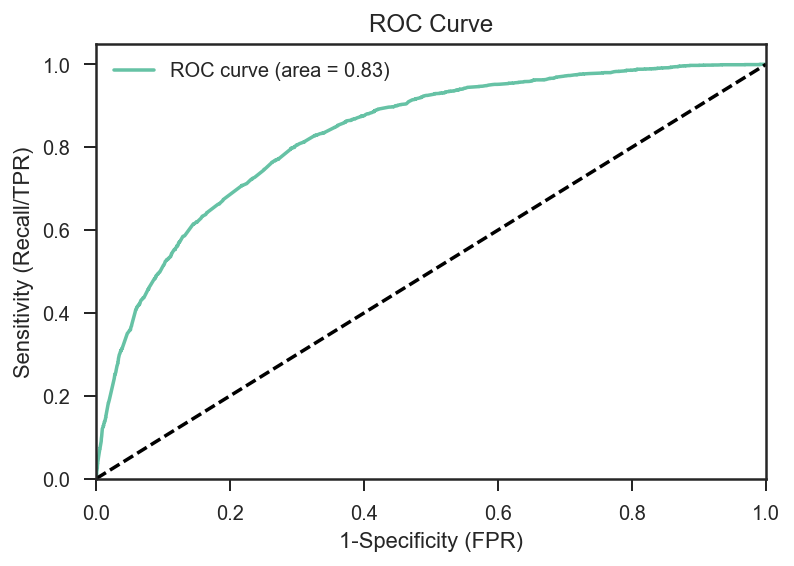

In [109]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (Recall/TPR)')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()